# Transformer activity
In this activity, we will build a transformer to do a regression task based on discrete sequential inputs (very similar to the RNA project).

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import numpy as np
from sklearn.model_selection import train_test_split

import pickle

In [2]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE

'cpu'

# Setup the data

We will build a custom dataset for this dataset.

For the input data:
- `0` represents padding
- `1` represents "Up"
- `2` represents "Down"
- `3` represents "Left"
- `4` represents "Right"

Outputs are also set to 0 for padded indices. Both inputs and outputs have a maximum sequence length of 32.

We should also make an attention mask that is `True` when the input is 0 and `False` otherwise.

In [3]:
# For Colab
# !git clone https://github.com/trevor-yu-087/syde-599-f23-tutorial.git
# DATA_PATH = "syde-599-f23-tutorial/data/transformer-data.pkl"
DATA_PATH = "./data/transformer-data.pkl"

In [4]:
with open(DATA_PATH, "rb") as f:
    data = pickle.load(f)

In [5]:
# Split into train and test datasets
X_train, X_test, y_train, y_test = train_test_split(data["inputs"], data["targets"], test_size=10_000, random_state=0)

In [6]:
# Create custom torch map-style dataset by implementing __len__ and __getitem__
# Example: https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#dataset-class

class AntHillDataset(torch.utils.data.Dataset):
    def __init__(self, inputs, targets):
        """
        inputs: list of np.array, input move sequences encoded as integers. 
        targets: list of np.array, output height values.
        """
        self.inputs = inputs
        self.targets = targets

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        """Retreive one item of the dataset at specified index.
        Parameters:
        -----------
        idx: int

        Returns: 
        --------
        (input, target, padding_mask): Tuple of torch.LongTensor, torch.FloatTensor, torch.BoolTensor.
        All have shape (1, 32). padding_mask is True when that position is a padding element.
        """
        input = self.inputs[idx]
        target = self.targets[idx]
        padding_mask = input == 0  # True when 0, do not attend to padded items
        
        input = torch.LongTensor(input)
        target = torch.FloatTensor(target)
        padding_mask = torch.BoolTensor(padding_mask)
        
        return input, target, padding_mask

In [7]:
train_ds = AntHillDataset(X_train, y_train)
test_ds = AntHillDataset(X_test, y_test)

In [8]:
train_ds[1]

(tensor([1, 4, 2, 3, 3, 2, 2, 2, 1, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]),
 tensor([ 3.6337e+00,  2.4338e+00,  2.9369e+00, -1.2263e-01, -3.2764e+00,
         -2.5587e+00, -2.2162e+00, -1.1073e-01, -2.2162e+00, -1.1073e-01,
         -4.2430e-04,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00]),
 tensor([False, False, False, False, False, False, False, False, False, False,
         False,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True]))

To improve dataloader performance, pinning memory during dataloading can help. You will notice performance improvements after the first epoch.

In [9]:
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=128, shuffle=True, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=128, shuffle=False, pin_memory=True)

# Building the model

## Sinusoidal Position Encodings

Complete the formula for the position encoding (the argument to the sine and cosine). The odd dimension indices get sine features, while the even dimension indices get cosine features. $D$ is the embedding dimension, and $N$ is the sequence length.

$\mathbf{p}[k, 2i] = sin(k / 10000^{2i / D}); \ i = 1,...,D//2; \ k = 1,...,N$

$\mathbf{p}[k, 2i+1] = cos(k / 10000^{2i / D}); \ i = 1,...,D//2; \ k = 1,...,N$

In [10]:
from typing import Optional

class SinusoidalPositionalEmbedding(nn.Embedding):
    """This module produces sinusoidal positional embeddings of any length."""
    def __init__(self, num_positions: int, embedding_dim: int, padding_idx: Optional[int] = None) -> None:
        super().__init__(num_positions, embedding_dim)
        self.weight = self._init_weight(self.weight)

    @staticmethod
    def _init_weight(out: nn.Parameter) -> nn.Parameter:
        """
        Interleaved sine and cosine position embeddings
        """
        out.requires_grad = False
        out.detach_()
        
        N, D = out.shape

        ## TODO: Create a N x D//2 array of position encodings (argument to the sine/cosine)
        inds = np.arange(0, D // 2)
        k = np.arange(N)
        denom = 1 / np.power(10_000, 2*inds / D)
        position_enc = np.outer(k, denom)  # Efficiently make N x D//2 array for all positions/dimensions
        #####

        out[:, 0::2] = torch.FloatTensor(np.sin(position_enc))  # Even indices get sin
        out[:, 1::2] = torch.FloatTensor(np.cos(position_enc))  # Odd indices get cos
        return out

    @torch.no_grad()
    def forward(self, input_ids_shape: torch.Size, past_key_values_length: int = 0) -> torch.Tensor:
        """`input_ids_shape` is expected to be [bsz x seqlen]."""
        bsz, seq_len = input_ids_shape[:2]
        positions = torch.arange(
            past_key_values_length, past_key_values_length + seq_len, dtype=torch.long, device=self.weight.device
        )
        return super().forward(positions)

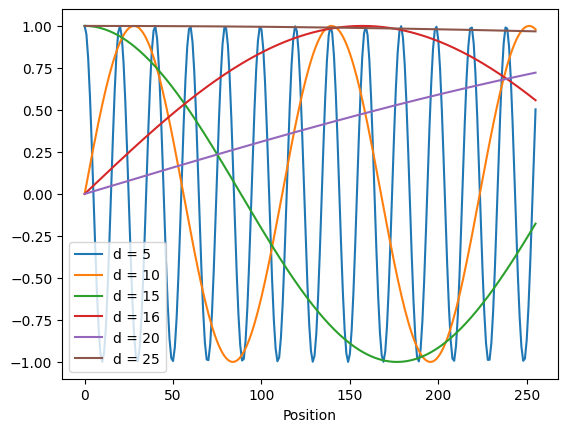

In [11]:
# TODO: Run this cell to test your implementation
input_ids = torch.zeros(64, 256, 30)

spe = SinusoidalPositionalEmbedding(num_positions=256, embedding_dim=32)
# Note that the forward takes the input shape as the argument
out = spe(input_ids.shape)

# Plot some dimensions to compare
import matplotlib.pyplot as plt
inds_to_plot = [5, 10, 15, 16, 20, 25]
for i in inds_to_plot:
    plt.plot(out[:, i], label=f"d = {i}")
plt.xlabel("Position")
plt.legend()
plt.show()

## Transformer model
Transformer models typically have 3 stages:
1. Input stage: Embedding layers to process inputs
2. Processing stage: Transformer blocks
3. Output stage: Process sequential output for specific task (e.g. classification head, regression head)

For this model, we'll use the `nn.Embedding` module to create vector embeddings for our input space, and sinusoidal position encodings, though a learned position embedding could also be used too.

For the transformer blocks, we'll use a bi-directional transformer encoder. We'll use the `GELU` activation, norm-first architecture, and batch first tensor shapes.

Note for tensor inputs:
- N = 32 (sequence length)
- D = 128 (hidden dimension)
- H = 4 (number of heads)
- D_FFN = 2 * D
- Input shape: (B, N, D)
- Output shape: (B, N)

In [12]:
class AntHillTransformer(nn.Module):
    def __init__(self, d_model=128, n_head=4, n_layers=3):
        super().__init__()
        self.d_model = d_model
        self.n_head = n_head
        self.n_layers = n_layers

        # Input embedding layers
        # TODO: Create input embedding and position encoding layers
        self.input_embeddings = nn.Embedding(num_embeddings=5, embedding_dim=d_model, padding_idx=0)
        self.position_encoding = SinusoidalPositionalEmbedding(num_positions=32, embedding_dim=d_model)
        ###
        self.input_layer_norm = nn.LayerNorm(d_model)

        # Transformer layers
        # TODO: Create encoder layer and transformer encoder stack
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=self.d_model,
            nhead=self.n_head,
            dim_feedforward=2*d_model,
            dropout=0.1,
            activation="gelu",
            batch_first=True,
            norm_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=self.n_layers)
        ###

        # Output layers
        self.output_norm = nn.LayerNorm(d_model)  # With pre-layer norm transformer, we should do one more before output
        # TODO: Create output linear layer
        self.output_layer = nn.Linear(128, 1)
        ###

    def forward(self, input_ids, padding_mask):
        """
        Parameters:
        -----------
        inputs: torch.LongTensor of shape (B, N, D)
        padding_mask: torch.BoolTensor of shape (B, N)
        
        Returns:
        --------
        outputs: torch.FlaotTensor of shape (B, N)
        """
        # TODO: Fill in forward layer
        # Inputs
        embedding_vectors = self.input_embeddings(input_ids)
        position_vectors = self.position_encoding(input_ids.shape)
        inputs = embedding_vectors + position_vectors  # Add position encodings
        inputs = self.input_layer_norm(inputs)

        # Transformer
        outputs = self.transformer_encoder(inputs, src_key_padding_mask=padding_mask)

        # Output layers
        outputs = self.output_norm(outputs)
        outputs = self.output_layer(outputs)
        outputs = outputs.squeeze()
        ###
        return outputs

In [13]:
model = AntHillTransformer()

(inputs, targets, mask) = next(iter(test_loader))
outputs = model(inputs, mask)
outputs.shape

torch.Size([128, 32])

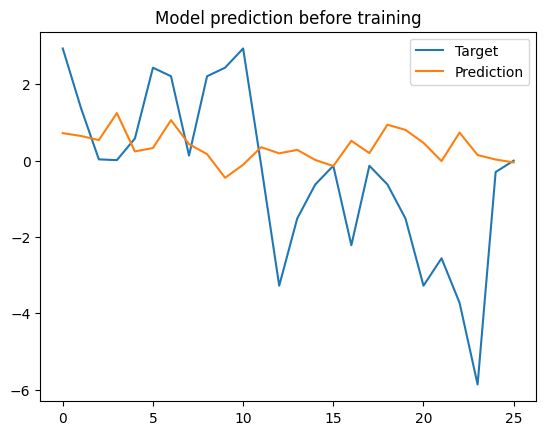

In [14]:
i = 0
m = mask[i, :].detach().cpu().numpy()
tgt = targets[i, :].detach().cpu().numpy()
y = outputs[i, :].detach().cpu().numpy()

plt.plot(tgt[~m], label="Target")
plt.plot(y[~m], label="Prediction")
plt.legend()
plt.title("Model prediction before training")
plt.show()

## Loss function

We need our loss function to only compute the loss over the non-masked examples.

In [15]:
# Outputs should be shape (B, N) = (128, 32)
def masked_mse(outputs, targets, mask):
    # TODO: Compute loss over non-masked elements
    mask = ~mask  # Invert padding mask
    outputs = torch.masked_select(outputs, mask)  # Note: masked_select flattens output
    targets = torch.masked_select(targets, mask)
    loss = F.mse_loss(outputs, targets)
    ###
    return loss

In [16]:
loss = masked_mse(outputs, targets, mask)
loss

tensor(5.2033, grad_fn=<MseLossBackward0>)

# Setup training loop
Note we modify the training loop from MNIST to include the mask.

In [17]:
def train(model, train_loader, loss_fn, optimizer, epoch=-1):
    """
    Trains a model for one epoch (one pass through the entire training data).

    :param model: PyTorch model
    :param train_loader: PyTorch Dataloader for training data
    :param loss_fn: PyTorch loss function
    :param optimizer: PyTorch optimizer, initialized with model parameters
    :kwarg epoch: Integer epoch to use when printing loss and accuracy
    :returns: Accuracy score
    """
    total_loss = 0
    all_predictions = []
    all_targets = []
    loss_history = []

    model = model.to(DEVICE)
    model.train()  # Set model in training mode
    for i, (inputs, targets, mask) in enumerate(train_loader):
        optimizer.zero_grad()
        inputs, targets, mask = inputs.to(DEVICE), targets.to(DEVICE), mask.to(DEVICE)
        outputs = model(inputs, mask)
        loss = loss_fn(outputs, targets, mask)
        loss.backward()
        optimizer.step()

        # Track some values to compute statistics
        total_loss += loss.item()

        # Save loss every 100 batches
        if (i % 100 == 0) and (i > 0):
            running_loss = total_loss / (i + 1)
            loss_history.append(running_loss)
            # print(f"Epoch {epoch + 1}, batch {i + 1}: loss = {running_loss:.2f}")

    final_loss = total_loss / len(train_loader)
    # Print average loss and accuracy
    print(f"Epoch {epoch + 1} done. Average train loss = {final_loss:.2f}")
    return final_loss

In [18]:
def test(model, test_loader, loss_fn, epoch=-1):
    """
    Tests a model for one epoch of test data.

    Note:
        In testing and evaluation, we do not perform gradient descent optimization, so steps 2, 5, and 6 are not needed.
        For performance, we also tell torch not to track gradients by using the `with torch.no_grad()` context.

    :param model: PyTorch model
    :param test_loader: PyTorch Dataloader for test data
    :param loss_fn: PyTorch loss function
    :kwarg epoch: Integer epoch to use when printing loss and accuracy

    :returns: Accuracy score
    """
    total_loss = 0
    all_predictions = []
    all_targets = []
    model = model.to(DEVICE)
    model.eval()  # Set model in evaluation mode
    for i, (inputs, targets, mask) in enumerate(test_loader):
        inputs, targets, mask = inputs.to(DEVICE), targets.to(DEVICE), mask.to(DEVICE)
        with torch.no_grad():
            outputs = model(inputs, mask)
            loss = loss_fn(outputs, targets, mask)

            # Track some values to compute statistics
            total_loss += loss.item()

    final_loss = total_loss / len(test_loader)
    # Print average loss and accuracy
    print(f"Epoch {epoch + 1} done. Average test loss = {final_loss:.2f}")
    return final_loss

# Test the implementation
Train a model for 5 epochs with both custom and PyTorch optimizer.

In [19]:
LEARNING_RATE = 1e-3
NUM_EPOCHS = 5
torch.manual_seed(0)
model = AntHillTransformer()
optimizer = torch.optim.Adam(model.parameters(), LEARNING_RATE)
loss_fn = masked_mse

In [20]:
train_losses = []
test_losses = []

for epoch in range(NUM_EPOCHS):
    train_loss = train(model, train_loader, loss_fn, optimizer, epoch)
    test_loss= test(model, test_loader, loss_fn, epoch)

    train_losses.append(train_loss)
    test_losses.append(test_loss)

Epoch 1 done. Average train loss = 2.15


/Users/trevoryu/.venv/datasci/lib/python3.10/site-packages/torch/nn/modules/transformer.py:562: UserWarning: Converting mask without torch.bool dtype to bool; this will negatively affect performance. Prefer to use a boolean mask directly. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/transformers/attention.cpp:152.)
  return torch._transformer_encoder_layer_fwd(


Epoch 1 done. Average test loss = 0.85
Epoch 2 done. Average train loss = 0.79
Epoch 2 done. Average test loss = 0.43
Epoch 3 done. Average train loss = 0.55
Epoch 3 done. Average test loss = 0.38
Epoch 4 done. Average train loss = 0.44
Epoch 4 done. Average test loss = 0.26
Epoch 5 done. Average train loss = 0.40
Epoch 5 done. Average test loss = 0.12


In [21]:
# View an example from the test dataset
model.eval()
with torch.no_grad():
    (inputs, targets, mask) = next(iter(test_loader))
    outputs = model(inputs, mask)

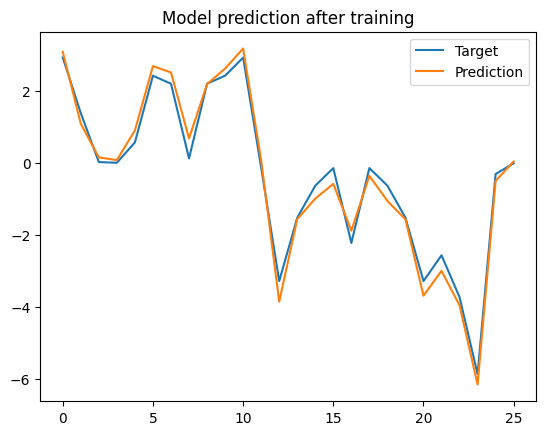

In [22]:
i = 0
m = mask[i, :].cpu().numpy()
tgt = targets[i, :].cpu().numpy()
y = outputs[i, :].cpu().numpy()

plt.plot(tgt[~m], label="Target")
plt.plot(y[~m], label="Prediction")
plt.legend()
plt.title("Model prediction after training")
plt.show()